In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Synthetic Data Generation with CTGAN

In [ ]:
!pip install ctgan
!pip install table_evaluator

### Remove unnecessary columns and encode all data

Next, we read the data into a dataframe and drop the unnecessary columns.

In [ ]:
import pandas as pd
filepath="/content/drive/MyDrive/Colab Notebooks/UNR-IDD.csv"

data = pd.read_csv(filepath)

Selection du label TCP-SYN et Normal

In [ ]:
data=data[(data.Label=='Diversion') | (data.Label=='Normal')]

In [ ]:
data.head()

,Switch ID,Port Number,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Rx Dropped,Packets Tx Dropped,Packets Rx Errors,...,Unknown Load/Latest,Latest bytes counter,is_valid,Table ID,Active Flow Entries,Packets Looked Up,Packets Matched,Max Size,Label,Binary Label
17501,of:000000000000000c,Port#:1,49,3622,17103,170,104,0,0,0,...,0,0,True,0,4,582,442,-1,Diversion,Attack
17502,of:000000000000000c,Port#:2,49,3622,17131,170,104,0,0,0,...,0,0,True,0,4,582,442,-1,Diversion,Attack
17503,of:000000000000000c,Port#:3,193,18967,16405,149,104,0,0,0,...,0,0,True,0,4,582,442,-1,Diversion,Attack
17504,of:000000000000000c,Port#:4,143,14851,15761,155,104,0,0,0,...,0,0,True,0,4,582,442,-1,Diversion,Attack
17505,of:000000000000000a,Port#:1,49,3622,17111,170,104,0,0,0,...,6302552,616982,True,0,6,886,748,-1,Diversion,Attack


J'ai retirer la colonne 'Switch ID' car les ID sont difficilement modélisés du fait qu'ils sont uniques et donc affaiblirai le résultat final

In [ ]:
data=data.drop('Switch ID',axis=1)

Pour avoir un aperçu géneral des données, il faut utiliser la statistique descriptive.
Le but est de voir comment sont réparties les données pour pouvoir les comparer avec la repartition des données synthétiques générés.

In [ ]:
data.describe()

,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Rx Dropped,Packets Tx Dropped,Packets Rx Errors,Packets Tx Errors,Delta Received Packets,...,Total Load/Rate,Total Load/Latest,Unknown Load/Rate,Unknown Load/Latest,Latest bytes counter,Table ID,Active Flow Entries,Packets Looked Up,Packets Matched,Max Size
count,9388.000000,9.388000e+03,9.388000e+03,9388.000000,9388.000000,9388.0,9388.0,9388.0,9388.0,9388.000000,...,9.388000e+03,9.388000e+03,9.388000e+03,9.388000e+03,9.388000e+03,9388.0,9388.000000,9.388000e+03,9.388000e+03,9388.0
mean,63902.953664,6.122696e+07,5.701686e+07,113472.442586,1899.268641,0.0,0.0,0.0,0.0,15.801875,...,2.126820e+04,5.002535e+05,2.126820e+04,5.002535e+05,2.126820e+04,0.0,17.600447,3.138347e+05,3.136658e+05,-1.0
std,112350.990521,4.880804e+07,4.373596e+07,145353.610669,819.381027,0.0,0.0,0.0,0.0,35.475599,...,1.159700e+05,1.768406e+06,1.159700e+05,1.768406e+06,1.159700e+05,0.0,45.069930,3.835636e+05,3.835973e+05,0.0
min,14.000000,1.136000e+03,1.574700e+04,143.000000,104.000000,0.0,0.0,0.0,0.0,0.000000,...,-6.303740e+05,0.000000e+00,-6.303740e+05,0.000000e+00,-6.303740e+05,0.0,4.000000,4.010000e+02,2.960000e+02,-1.0
25%,2002.000000,2.040629e+07,2.532986e+07,2701.750000,1232.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,4.000000,1.129500e+04,1.109600e+04,-1.0
50%,3808.500000,5.046820e+07,4.487194e+07,5297.500000,1957.000000,0.0,0.0,0.0,0.0,2.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,6.000000,2.164250e+04,2.141200e+04,-1.0
75%,117934.250000,8.832225e+07,8.230654e+07,248327.750000,2597.000000,0.0,0.0,0.0,0.0,4.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,7.000000,6.566020e+05,6.564740e+05,-1.0
max,352772.000000,2.715925e+08,2.392430e+08,421598.000000,3317.000000,0.0,0.0,0.0,0.0,167.000000,...,1.260666e+06,1.891030e+07,1.260666e+06,1.891030e+07,1.260666e+06,0.0,207.000000,1.012574e+06,1.012439e+06,-1.0


En regardant les valeurs min, on s'aperçoit que la majeure partie des données sont strictement positifs, donc il faut faire attention à ce que les données synthétiques générés par le modèle suivent aussi cette tendance.

On liste ensuite les variables catégoriques afin que le modèle puisse savoir comment les traiter pendant l'entraînement

In [ ]:
categorical_features = ['Label', 'Binary Label', 'is_valid', 'Port Number']

## Training the model

Ensuite, on définie une instance de `CTGANSynthesizer` and on appelle la méthode de fonction `fit` sur les données avec la liste des variables catégoriques

Ici j'ai utilisé 300 epochs

In [ ]:
!pip uninstall numpy --y
!pip install numpy

Found existing installation: numpy 1.25.2
Uninstalling numpy-1.25.2:
  Successfully uninstalled numpy-1.25.2
  Using cached numpy-1.25.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.2 which is incompatible.


Il y a eu un problème avec python 3.10 et numpy donc j'ai dû reinstaller numpy

In [ ]:
from ctgan import CTGAN as CTGANSynthesizer

ctgan = CTGANSynthesizer()
ctgan.fit(data, categorical_features, epochs = 300)

/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f46b54d0e50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 847, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 984, in _make_controller_from_path
    lib_controller = controller_class(filepath=filepath, prefix=prefix)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 111, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py

## Evaluation

Après l'entraînement du modèle, j'ai généré 1000 échantillons de données synthétiques pour comparer avec la donnée originale en terme de distribution.

In [ ]:
samples = ctgan.sample(1000)

print(samples.head())

  Port Number  Received Packets  Received Bytes  Sent Bytes  Sent Packets  \
0     Port#:1              5546       118807796    70878443        218690   
1     Port#:2            181753       158631379   138134635        252549   
2     Port#:3              4773        45486727    25331610          4736   
3     Port#:1              4915        60239969    19389662          5299   
4     Port#:4            362037        69573818    12970260        214792   

   Port alive Duration (S)  Packets Rx Dropped  Packets Tx Dropped  \
0                     2889                   0                   0   
1                      959                   0                   0   
2                     1544                   0                   0   
3                     3119                   0                   0   
4                     1074                   0                   0   

   Packets Rx Errors  Packets Tx Errors  ...  Unknown Load/Latest  \
0                  0                  0  ...   

In [ ]:
samples.to_csv("Sample_Synthetic_UNR-IDD.csv", index = False)

Ici, on voit que beaucoup de variables ont une valeur négative, ce qui ne devrait pas être le cas car comme on a vu avec les données réelles , les valeurs des bits par exemple sont des entiers strictement positifs.
Une piste pour y remédier serait de rendre nul les valeurs en dessous de zéro car le modèle CTGAN ne comprends pas encore cette caractéristique de la colonne.

Maintenant, comparons graphiquement la distribution des données réelles et synthétiques côte à côte avec la librairie `table_evaluator`

(9388, 33) (1000, 33)


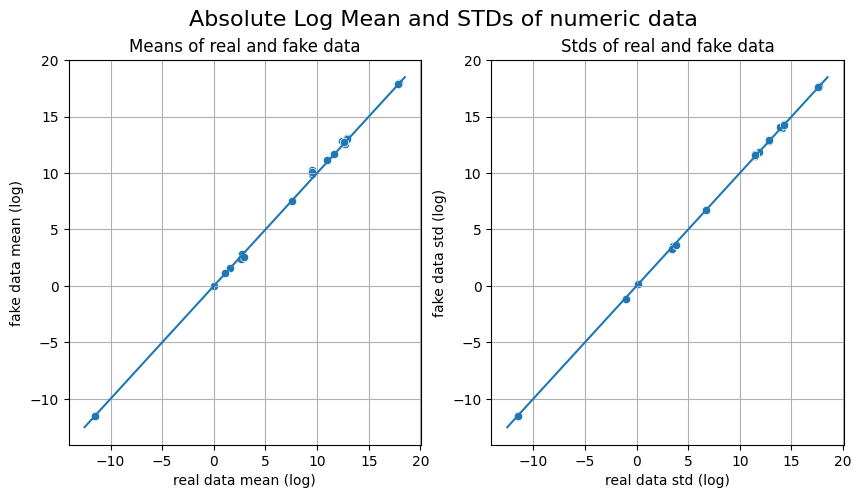

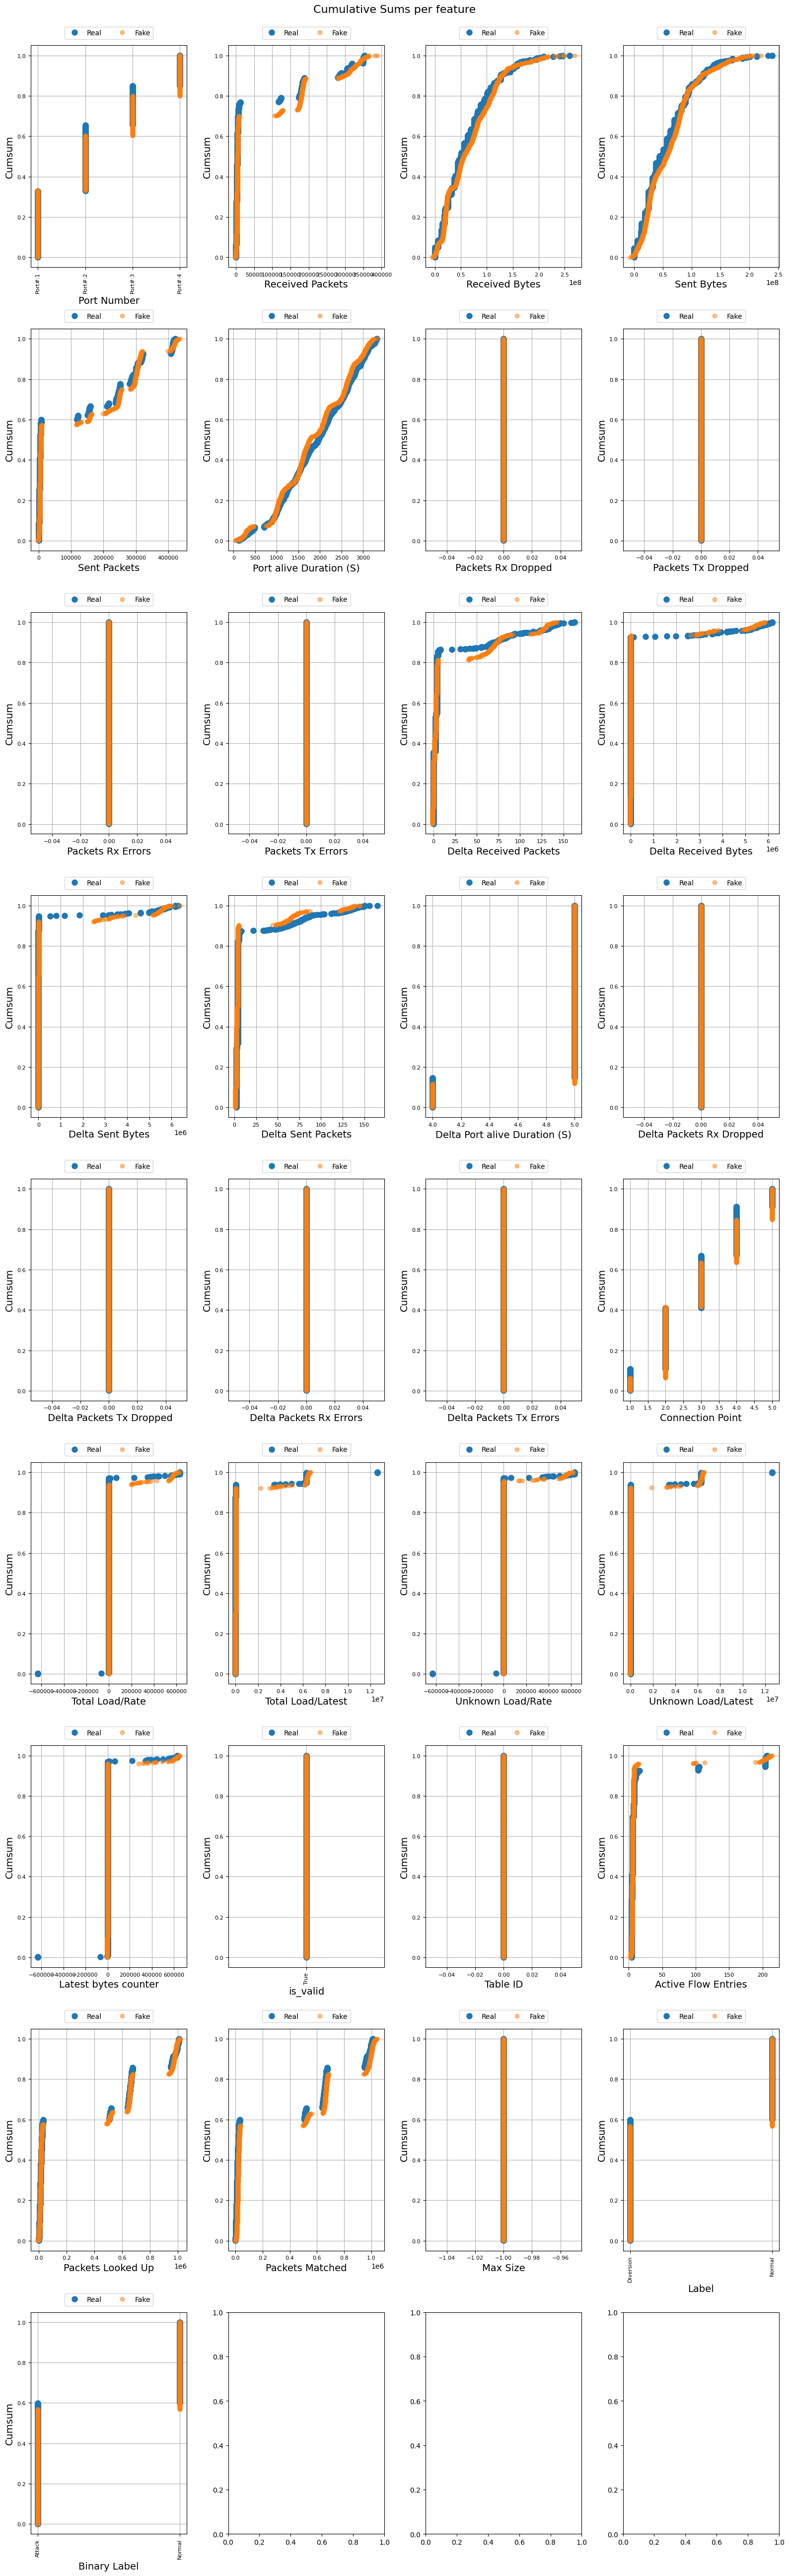

/usr/local/lib/python3.10/dist-packages/table_evaluator/table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * self.n_samples + ['fake'] * self.n_samples})
/usr/local/lib/python3.10/dist-packages/table_evaluator/table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * self.n_samples + ['fake'] * self.n_samples})
/usr/local/lib/python3.10/dist-packages/table_evaluator/table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * s

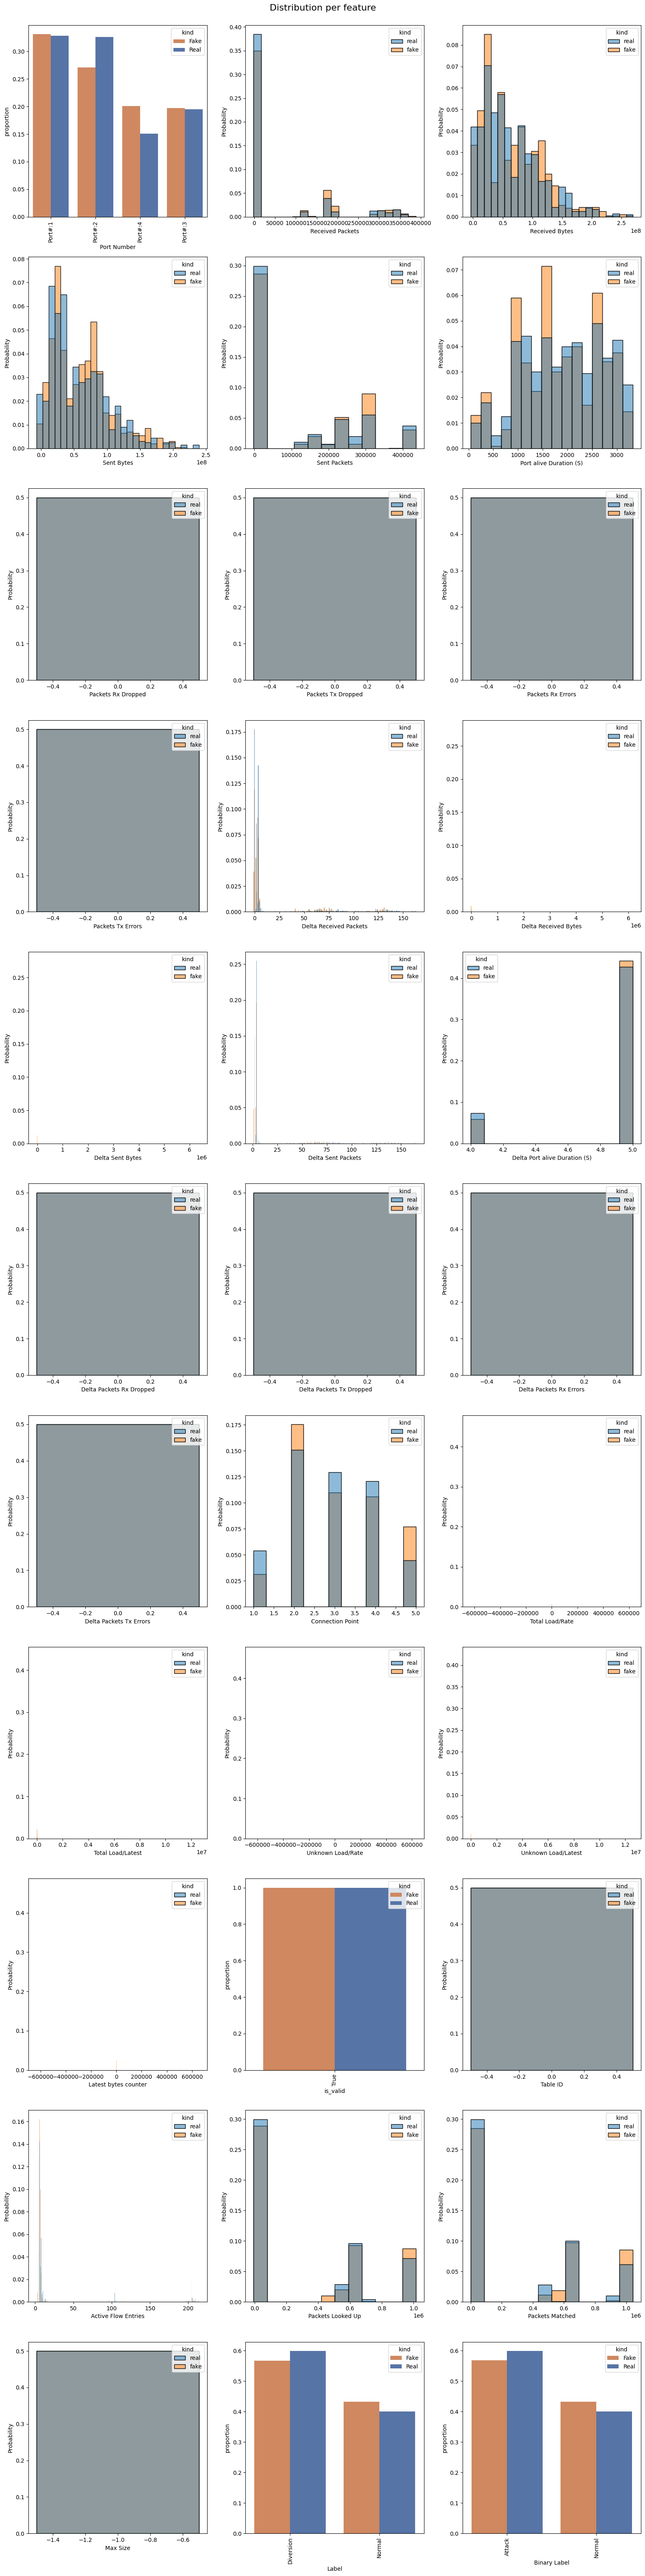

TypeError: ignored

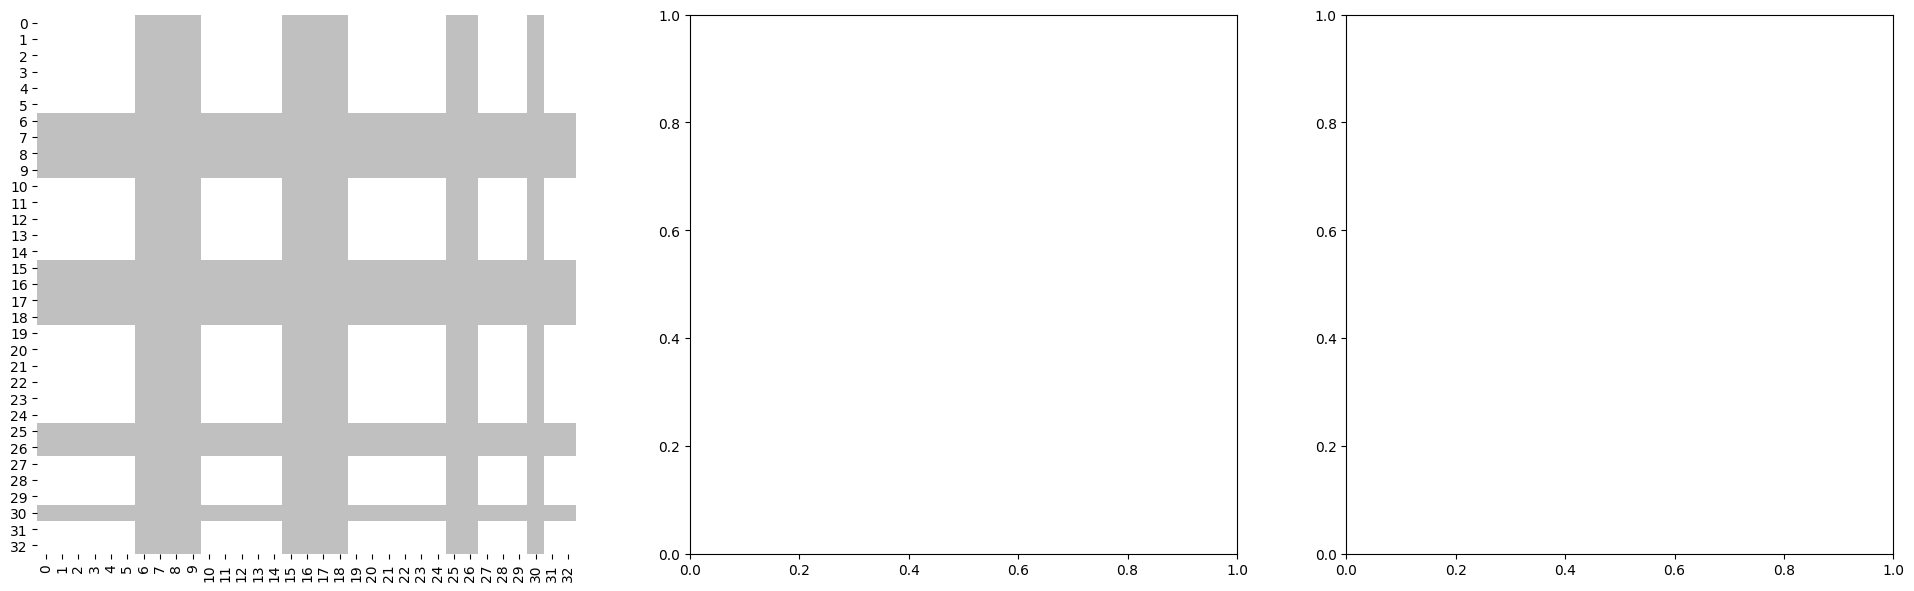

In [ ]:
from table_evaluator import load_data, TableEvaluator

print(data.shape, samples.shape)
table_evaluator =  TableEvaluator(data, samples, cat_cols= categorical_features)

table_evaluator.visual_evaluation()


## Conclusion
Graphiquement les similitude entre les données synthétiques et réelles sont déjà très élevés, cependant il y certaines spécificités des données réelles que le modèle CTGAN n'a pas encore assimilé comme les valeurs strictement positifs.
Pour mieux évaluer et quantifier ces similitudes il faut modéliser avec les données synthétiques.

## Remarque
Pour mieux évaluer la pertinence des données synthétiques il faut diviser les données originaux en deux en D_train et D_test.

Ensuite il faut entrainer un modèle de prédiction (random forest, decision tree etc... ) avec les données synthétiques D_synth et les données originaux D_train. Et enfin comparer performances des deux modèles sur les données réelles D_test.

Si la performance des deux modèles sont plus ou moins proches, alors on peut conclure que les données synthétiques générés sont relativement fidèles à l'original